<a href="https://colab.research.google.com/github/asmita-mukherjee/Learning_scratchPad/blob/main/Fine_Tuning_BERT_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reference from : https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [ ]:
EPOCHS = 50

##Imports

In [ ]:
import torch

In [ ]:
%%capture
pip install transformers

In [ ]:
import pandas as pd

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [ ]:
from torch.optim import AdamW

##Fetching the data : https://nyu-mll.github.io/CoLA/

> Corpus of Lingustic acceptability, Sentences annotated for acceptability in regards to its grammer

In [ ]:
import os

In [ ]:
%%capture
pip install wget

In [ ]:
import wget

In [ ]:
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
if not os.path.exists('./cola_public_1.1'):
  !unzip "./cola_public_1.1.zip"


Archive:  ./cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## Setting up device (obviously the most important step)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Sneak into the dataset

In [ ]:
train_data = pd.read_csv("/content/cola_public/raw/in_domain_train.tsv",delimiter='\t',header=None,names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
train_data.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8551 entries, 0 to 8550
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence_source  8551 non-null   object
 1   label            8551 non-null   int64 
 2   label_notes      2527 non-null   object
 3   sentence         8551 non-null   object
dtypes: int64(1), object(3)
memory usage: 267.3+ KB


We only need the sentence and the label and those 2 cols do not have null

In [ ]:
train_data.columns

Index(['sentence_source', 'label', 'label_notes', 'sentence'], dtype='object')

In [ ]:
train_data = train_data[["sentence","label"]]

In [ ]:
train_data

,sentence,label
0,"Our friends won't buy this analysis, let alone...",1
1,One more pseudo generalization and I'm giving up.,1
2,One more pseudo generalization or I'm giving up.,1
3,"The more we study verbs, the crazier they get.",1
4,Day by day the facts are getting murkier.,1
...,...,...
8546,Poseidon appears to own a dragon,0
8547,Digitize is my happiest memory,0
8548,It is easy to slay the Gorgon.,1
8549,I had the strangest feeling that I knew you.,1


In [ ]:
sentences = train_data.sentence
labels = train_data.label

### Setting up the bert tokenizer

> To feed our text data to the bert model, it needs to be formatted in a specific way i.e the way the bert model's input was formatted during pretraining. Also it needs to be mapped to the bert vocabulary, so that the text can be converted to vectors

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True) #loading the bert tokenizer from its pretrained model in the hugging face cloud

#### What does the tokenizer actually do?

In [ ]:
sample = sentences[0]

print(f"Original -> \n {sample}")

print("\n")

print(f"Tokenized -> \n {tokenizer.tokenize(sample)}")

print("\n")
print(f"Token ids after tokenization -> \n {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample))}")

print("\n")
print(f"Tokenizer encode -> \n {tokenizer.encode(sample)}")

print("\n")

print(f"Tokenizer decode after encode -> \n {tokenizer.decode(tokenizer.encode(sample))}")


print("\n")
print(f"Tokenizer encode plus -> \n {tokenizer.encode_plus(sample)}")


Original -> 
 Our friends won't buy this analysis, let alone the next one we propose.


Tokenized -> 
 ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']


Token ids after tokenization -> 
 [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


Tokenizer encode -> 
 [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


Tokenizer decode after encode -> 
 [CLS] our friends won't buy this analysis, let alone the next one we propose. [SEP]


Tokenizer encode plus -> 
 {'input_ids': [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Thus tokenizer.encode adds the special tokens by default

## Thus let us prepare the customdataset and customdataloader required for pytorch training

In [ ]:
### Since each of our sentence vector must be of the same length ,hence find the max length of the encoded sentences
max_len=0

for sen in sentences:
  max_len = max(max_len,len(tokenizer.encode(sen)))

max_len


47

as per the author of the reference , setting the max length to be 64 , incase there are longer sentences in the test dataset

In [ ]:
def encode_sentences(sentences):
  input_ids =[]
  attention_masks = []


  for sen in sentences:
    encoded = tokenizer.encode_plus(sen,max_length=64,pad_to_max_length=True,return_tensors="pt")
    input_ids.append(encoded["input_ids"])
    attention_masks.append(encoded["attention_mask"])
  
  return input_ids,attention_masks


In [ ]:
train_input_ids,train_attention_mask = encode_sentences(sentences)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_input_ids = torch.cat(train_input_ids,dim=0)
train_input_ids.shape

torch.Size([8551, 64])

In [ ]:
train_attention_mask = torch.cat(train_attention_mask,dim=0)
train_attention_mask.shape

torch.Size([8551, 64])

In [ ]:
labels = torch.tensor(labels)
labels.shape

torch.Size([8551])

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,input_ids,attention_mask,labels):
    
    self.input_ids= input_ids.to(device)
    self.attention_mask = attention_mask.to(device)
    self.labels = labels.to(device)
    
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self,idx):
    return self.input_ids[idx],self.attention_mask[idx],self.labels[idx]


### Converting to Dataset and splitting to train and val set

In [ ]:
dataset = CustomDataset(train_input_ids,train_attention_mask,labels)

In [ ]:
train_length = int(0.9*len(dataset))
val_length = len(dataset) - train_length

In [ ]:
train_dataset,val_dataset = random_split(dataset,[train_length,val_length])

In [ ]:
len(train_dataset),len(val_dataset)

(7695, 856)

### loading to Dataloader

In [ ]:
train_dataloader= DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=32,shuffle=True)

### Load the model

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2,output_attentions=False,output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [51]:
model = model.to(device)  

#### Feezing the top 12 layers of bert

In [52]:
l = [1,2,3,4,5]
l[:-2]

[1, 2, 3]

In [53]:
model.parameters()

<generator object Module.parameters at 0x7f1bfdb37f40>

In [54]:
for name,param in list(model.named_parameters())[:12]:
  print(name)
  param.requires_grad=False

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight


## Set the optimizer

In [55]:
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

## Training loop

In [56]:
import time

In [57]:

def train_for_one_epoch(dataloader):
  
  t0 = time.time()

  total_loss = 0

  for idx,data in enumerate(train_dataloader):
    input_ids,attention_mask,labels = data

    optimizer.zero_grad()

    outputs = model(input_ids,attention_mask=attention_mask,labels=labels)

    loss = outputs.loss

    total_loss += loss.item()

    loss.backward()

    #clip the norm of the grad to 1.0
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

    optimizer.step()


  #avg_train_loss
  avg_train_loss = total_loss/len(train_dataloader)

  # Measure how long this epoch took.
  training_time = (time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epooch took: {:}".format(training_time))

  return avg_train_loss




In [58]:
def validation(dataloader):
  
  total_loss = 0

  for idx,data in enumerate(dataloader):
    input_ids,attention_mask,labels = data

    outputs = model(input_ids,attention_mask=attention_mask,labels=labels)
    loss = outputs.loss

    total_loss += loss.item()

  avg_loss = total_loss/len(dataloader)

  print("")
  print("  Average Validation loss: {0:.2f}".format(avg_loss))

  return avg_loss


In [59]:
list_of_train_loss = []
list_of_val_loss = []

for epoch in range(0,EPOCHS):
  
  #############################Training##########################################
  model.train()
  avg_train_loss = train_for_one_epoch(train_dataloader) #avg train loss for the dataset
  list_of_train_loss.append(avg_train_loss)

  #############################Validation##########################################
  model.eval()
  avg_val_loss  = validation(val_dataloader)
  list_of_val_loss.append(avg_val_loss)


  






  Average training loss: 0.32
  Training epooch took: 79.2056953907013

  Average Validation loss: 0.47

  Average training loss: 0.20
  Training epooch took: 79.49057984352112

  Average Validation loss: 0.66

  Average training loss: 0.14
  Training epooch took: 79.60934233665466

  Average Validation loss: 0.66

  Average training loss: 0.11
  Training epooch took: 79.4964952468872

  Average Validation loss: 0.72

  Average training loss: 0.09
  Training epooch took: 79.52828884124756

  Average Validation loss: 0.76

  Average training loss: 0.07
  Training epooch took: 79.47564148902893

  Average Validation loss: 0.94

  Average training loss: 0.06
  Training epooch took: 80.78760361671448

  Average Validation loss: 0.82

  Average training loss: 0.05
  Training epooch took: 80.6359384059906

  Average Validation loss: 0.98

  Average training loss: 0.04
  Training epooch took: 79.83895325660706

  Average Validation loss: 1.02

  Average training loss: 0.04
  Training epooch 

In [60]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [64]:
torch.save(model.state_dict,"/content/drive/MyDrive/Learning Scratch pad/bert_12_freezed_50_epoch")

##Plot the train and val loss

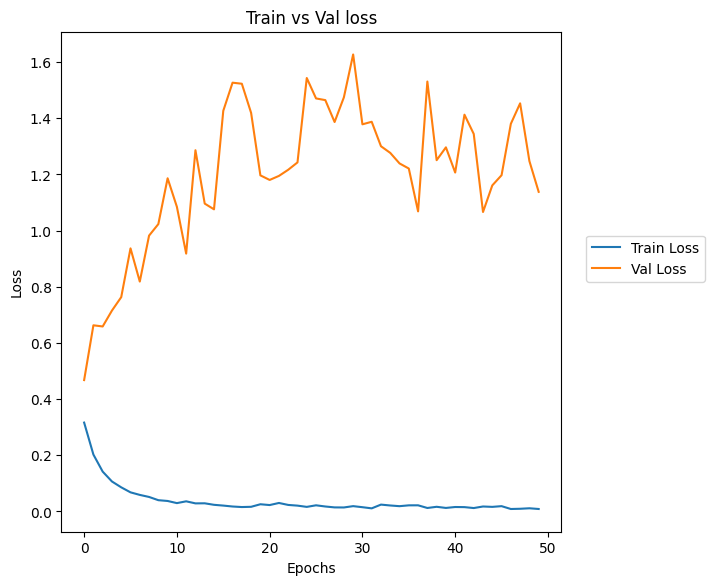

In [63]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))

axes = fig.add_axes([0,0,1,1])

axes.plot(range(0,EPOCHS),list_of_train_loss,label="Train Loss")
axes.plot(range(0,EPOCHS),list_of_val_loss,label="Val Loss")

plt.legend(loc=(1.05,0.5))

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Val loss")
plt.show()